## Task - 0

In [85]:
## importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.utils.data as data

In [ ]:
pip install torchviz

In [87]:
from torch.autograd import Variable

In [88]:
import cv2  ## importing cv2
from torchviz import make_dot

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  ## checking if cuda is available or not

In [90]:
input_size = 28 * 28
num_classes = 10
learning_rate = 0.01
batch_size = 64
num_epochs = 5

In [91]:
## defining transformations
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # random rotation within -15 to +15 degrees
    transforms.RandomCrop(size=28),  # randomly crop the image to size 224x224
    transforms.ToTensor(),  # convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # normalize the image
])

In [92]:
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
# train_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)

In [93]:
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transform, download=True)
# test_loader = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)

In [94]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = data.random_split(train_dataset, [train_size, validation_size])

In [95]:
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = data.DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=True)

## Task - 1

In [96]:
import matplotlib.pyplot as plt

In [97]:
import numpy as np
import random

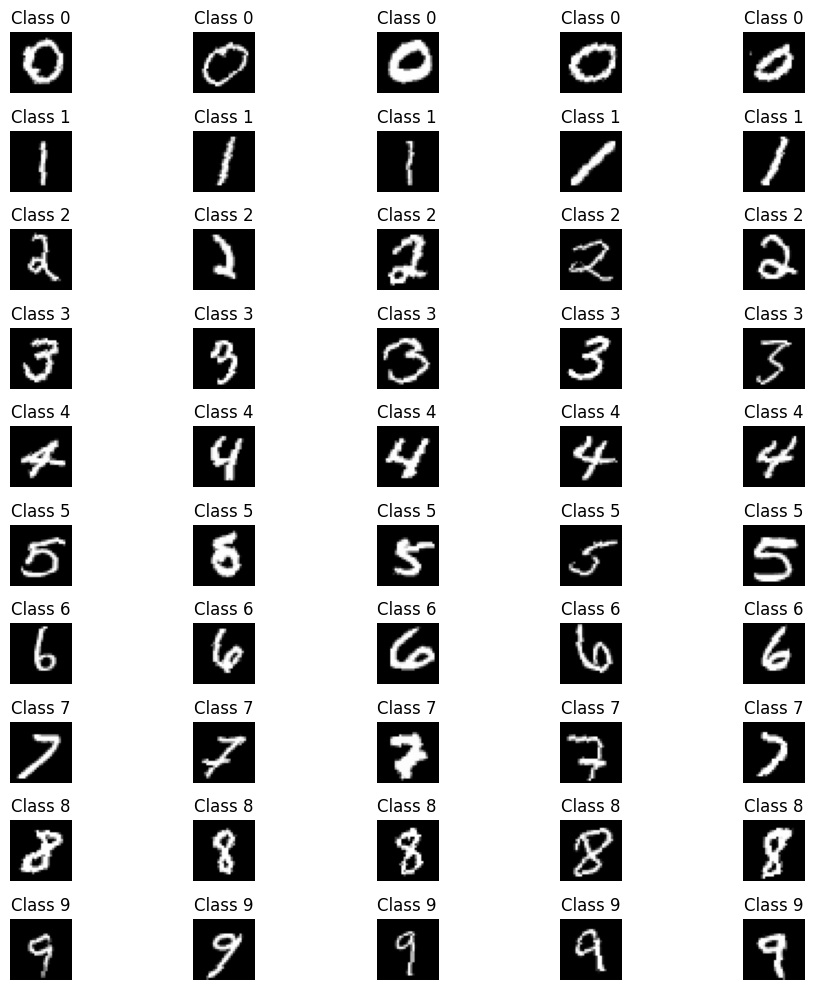

In [98]:
## displaying images from each class
samples_per_class = {i: [] for i in range(10)}

## iterating over the dataset to collect 5 samples from each class
for img, label in train_dataset:
    if len(samples_per_class[label]) < 5:
        samples_per_class[label].append(img)
    if all(len(samples_per_class[i]) == 5 for i in range(10)):
        break

## plotting the images
plt.figure(figsize=(10, 10))

## loop through the classes and plot the images
for class_idx in range(10):
    for img_idx, img in enumerate(samples_per_class[class_idx]):
        plt_idx = class_idx * 5 + img_idx + 1
        plt.subplot(10, 5, plt_idx)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f'Class {class_idx}')
        plt.axis('off')

plt.tight_layout()
plt.show()  ## displaying the plot

## Task - 2

In [99]:
## defining the model with layers named "NN"
class NN(nn.Module):
  ## defining the constructor
  def __init__(self, input_size, num_classes):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, num_classes)

  ## defining the forward function
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [100]:
model = NN(input_size=input_size, num_classes=num_classes)  ## defining the model

In [101]:
# create a sample input to visualize the model
x = torch.randn(1, 784)
x = Variable(x)

# generate the visualization
make_dot(model(x), params=dict(model.named_parameters())).render("model_tree", format="png", engine='dot')

# display the model tree
make_dot(model(x), params=dict(model.named_parameters())).view()

'Digraph.gv.pdf'

In [102]:
## printing total no of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 52650


In [103]:
## defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## Task - 3

In [104]:
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []
best_val_accuracy = 0.0

In [105]:
## defining the epochs
for epoch in np.arange(num_epochs):
  model.train()  # Set the model to training mode
  epoch_train_loss = 0.0
  correct_train = 0
  total_train = 0

  for batch_idx, (data, targets) in enumerate(train_loader):
    # data = data.to(device = device)
    # targets = targets.to(device = device)
    data = data.reshape(data.shape[0], -1)
    optimizer.zero_grad()
    scores = model(data)
    # print("Scores : ", scores)
    # print("Target : ", targets)
    loss = criterion(scores, targets)
    # loss_value = loss.detach().cpu().numpy()
    # loss1 = loss1 + loss_value

    loss.backward()

    optimizer.step()
    epoch_train_loss += loss.item()  # summing loss
    _, predicted = torch.max(scores, 1)  # get the predicted class
    correct_train += (predicted == targets).sum().item()  # count correct predictions
    total_train += targets.size(0)  # count total samples

  # calculate average train loss and accuracy
  avg_train_loss = epoch_train_loss / len(train_loader)
  train_accuracy = correct_train / total_train


  model.eval()  # set the model to evaluation mode
  epoch_validation_loss = 0.0
  correct_validation = 0
  total_validation = 0

  with torch.no_grad():
      for inputs, labels in validation_loader:
          inputs = inputs.view(-1, 784)  # flatten the input
          outputs = model(inputs)  # forward pass

          loss = criterion(outputs, labels)  # calculate loss
          epoch_validation_loss += loss.item()  # accumulate validation loss

          _, predicted = torch.max(outputs, 1)  # get the predicted class
          correct_validation += (predicted == labels).sum().item()  # count correct predictions
          total_validation += labels.size(0)  # count total samples

  # calculating average validation loss and accuracy
  avg_validation_loss = epoch_validation_loss / len(validation_loader)
  validation_accuracy = correct_validation / total_validation

  # logging train and validation metrics
  train_losses.append(avg_train_loss)
  train_accuracies.append(train_accuracy)
  validation_losses.append(avg_validation_loss)
  validation_accuracies.append(validation_accuracy)

  print(f"Epoch {epoch + 1}/{num_epochs}")
  print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
  print(f"Validation Loss: {avg_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

  # saving  the best model based on validation accuracy
  if validation_accuracy > best_val_accuracy:
      best_val_accuracy = validation_accuracy
      torch.save(model.state_dict(), 'best_model.pth')  ## saving the model

Epoch 1/5
Train Loss: 0.3699, Train Accuracy: 0.8862
Validation Loss: 0.2553, Validation Accuracy: 0.9247
Epoch 2/5
Train Loss: 0.2582, Train Accuracy: 0.9246
Validation Loss: 0.2492, Validation Accuracy: 0.9286
Epoch 3/5
Train Loss: 0.2328, Train Accuracy: 0.9338
Validation Loss: 0.2382, Validation Accuracy: 0.9358
Epoch 4/5
Train Loss: 0.2167, Train Accuracy: 0.9401
Validation Loss: 0.2246, Validation Accuracy: 0.9396
Epoch 5/5
Train Loss: 0.2118, Train Accuracy: 0.9414
Validation Loss: 0.2245, Validation Accuracy: 0.9361


## Task - 4

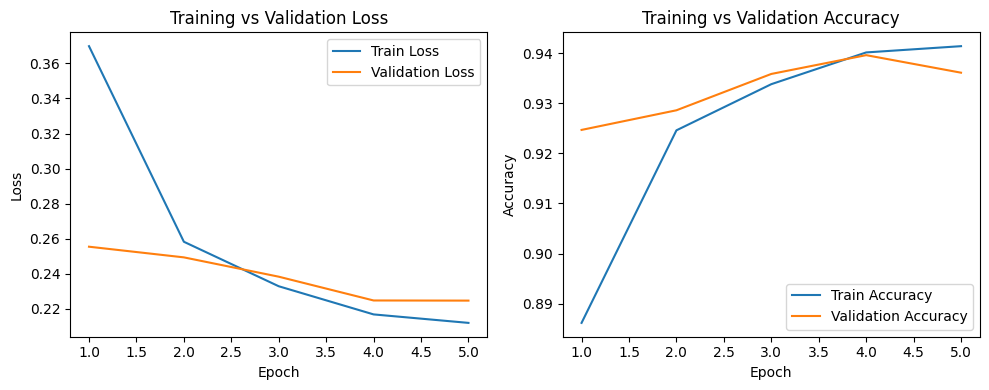

In [106]:
#display final results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [107]:
## list to store the predictions
correct_examples = []
incorrect_examples = []

In [108]:
def check_accuracy(loader, model):
  num_correct = 0  ## store the correct samples
  num_samples = 0  ## store the total samples
  model.eval()

  with torch.no_grad():
    for x,y in test_loader:
      # print(x,y)
      # x = x.to(device=device)
      # y = y.to(device=device)
      x = x.reshape(x.shape[0], -1)

      scores = model(x)
      _, predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

      ## comparing predictions with true labels
      correct_indices = (predictions == y).nonzero(as_tuple=True)[0]
      incorrect_indices = (predictions != y).nonzero(as_tuple=True)[0]

      ## appending the  correct examples
      correct_examples.extend(
          (x[i].view(28, 28), y[i].item(), predictions[i].item())
          for i in correct_indices
      )

      ## appending the incorrect examples
      incorrect_examples.extend(
          (x[i].view(28, 28), y[i].item(), predictions[i].item())
          for i in incorrect_indices
      )

    # print(num_correct / num_samples)
  model.train()
  return num_correct / num_samples

In [109]:
check_accuracy(test_loader, model)  ## printing the accuracy

tensor(0.9370)

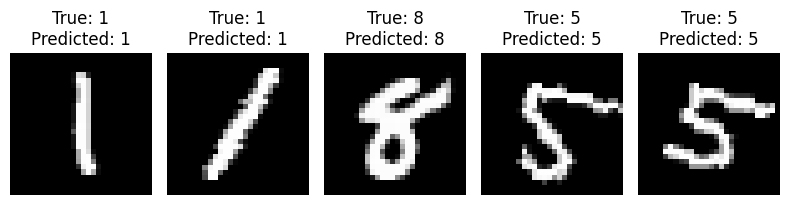

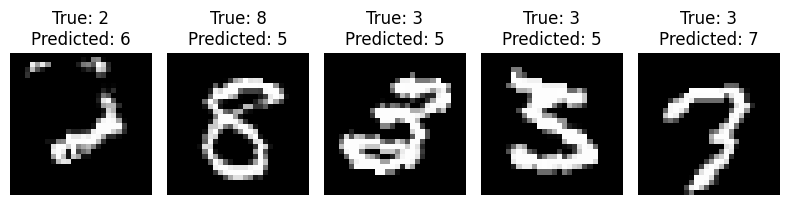

In [110]:
## visualizing the correct predictions
plt.figure(figsize=(8, 6))
for i, (img, true_label, pred_label) in enumerate(correct_examples[:5]):
    plt_idx = i + 1
    plt.subplot(1, 5, plt_idx)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## visualizing the incorrect predictions
plt.figure(figsize=(8, 6))
for i, (img, true_label, pred_label) in enumerate(incorrect_examples[:5]):
    plt_idx = i + 1
    plt.subplot(1, 5, plt_idx)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPredicted: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [111]:
from sklearn.decomposition import PCA ## importing the PCA

In [112]:
images = []
labels = []

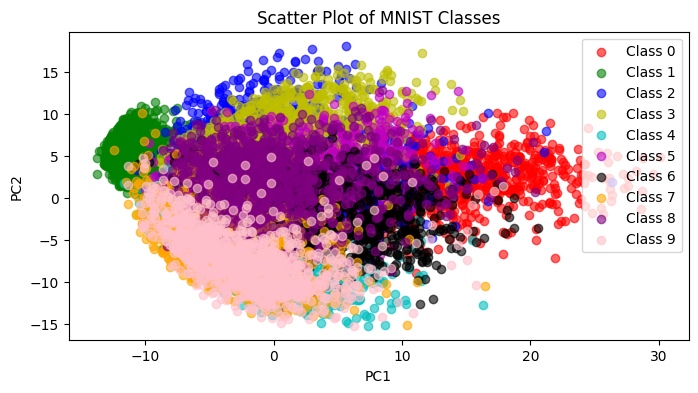

In [113]:
## plotting the classes of MNIST
for img, label in test_dataset:
    images.append(img.view(-1).numpy())  # flatten the image to 1D
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

## applying PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(images)

## plotting the scatter plot with colors representing each class
plt.figure(figsize=(8, 4))
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'orange', 'purple', 'pink']

## looping through the classes 0-9 and plot
for class_num in range(10):
    indices = (labels == class_num)
    plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=f'Class {class_num}', color=colors[class_num], alpha=0.6)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot of MNIST Classes')
plt.legend()  # adding a legend to show which color represents which class
plt.show()